## This notebook make scatterplots 
### based on data from res/[algo]/eval-[data].pkl"

Six scatter plots are made:
1. average f1 change when varying q & algo
2. average f1 change when varying q & data
3. average precision change when varying q & algo
4. average precision change when varying q & data
5. average recall change when varying q & algo
6. average recall change when varying q & data


In [ ]:
import os, sys, argparse
import pandas as pd
import numpy as np

import pickle
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
parser = argparse.ArgumentParser(description='heatmap creator')
parser.add_argument('-o', '--output', type=str, default='-', action='store', help='target')
parser.add_argument('-d', '--data', type=str, default='alpha', choices=['alpha', 'amazon', 'epinions', 'otc'], help='data name')
parser.add_argument('-a', '--alg', type=str, default='bad', choices=['bn', 'feagle', 'fraudar', 'trust', 'rsd', 'bad'], help='alg name')

if bool(getattr(sys, 'ps1', sys.flags.interactive)):
    from tqdm import tqdm_notebook as tqdm
    print('interactive mode')
    parsed = parser.parse_args(['--data', 'alpha', '--alg', 'bn'])
else:
    from tqdm import tqdm
    print('script mode')
    parsed = parser.parse_args(sys.argv[1:])
    display=print

print(parsed)

interactive mode
Namespace(alg='bn', data='alpha', output='-')


In [4]:
# alg_list = ['bn', 'feagle', 'fraudar', 'trust', 'rsd', 'bad', 'rev2']
alg_list = ['rev2', 'bad', 'bn', 'trust', 'feagle', 'fraudar', 'rsd']
# data_list = ['alpha', 'amazon', 'epinions', 'otc']
data_list = ['otc', 'alpha', 'epinions', 'amazon']
q_range = np.array([0.005, 0.01, 0.03, 0.05, 0.1])
met_list = ['f1', 'prec', 'recl']

k_range = np.arange(10) / 10
n_range = list(range(0, 51, 5))
n_range[0] = 1

In [11]:
from collections import defaultdict

data_list = ['otc','alpha','epinions','amazon']
alg_list = ['rev2', 'bad', 'bn', 'trust', 'feagle', 'fraudar', 'rsd']
markers = ["o", "v", "8", "s", "P", "*", "+"]

def compute_uchange():     #fig, ax, plot_data, title=''
    
    u_change_dict = {}     #u_change_dict[alg_id][met][q] = average_uchange = sum of u_change / # of valid dataset
    
    for alg_id in range(len(alg_list)): 
        u_change_dict[alg_id] = {}     
        for met in met_list:
            u_change_dict[alg_id][met] = {}
            
        for data in data_list:         
            eval_path = '../res/%s/eval-%s.pkl' %(alg_list[alg_id], data)                            
            try:
                with open(eval_path, 'rb') as fp:
                    metrics_dict = pickle.load(fp)
            except FileNotFoundError:
                print("no ../res/%s/eval-%s.pkl" %(alg_list[alg_id], data))
                continue
            
            print(alg_list[alg_id], data)
            
            
            q_dict = {}
            for q in range(5):
                heat_dict = {'f1': np.empty([10, 11]), 'prec': np.empty([10, 11]), 'recl': np.empty([10, 11])}
                
                try:
                    for k, n in itertools.product(range(10), range(11)):
                        heat_dict['f1'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['f1'][q_range[q]] for ind in range(50)])
                        heat_dict['prec'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['prec'][q_range[q]] for ind in range(50)])
                        heat_dict['recl'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['recl'][q_range[q]] for ind in range(50)])
                    q_dict[q] = heat_dict   
                except TypeError:
#                    print("TypeError Here !")
                    continue
            
            for q in range(5):  
                for met in met_list:
                    try:
                        # div = 0
                        u_new = q_dict[q][met][1:, :].min()
                        u_old = q_dict[q][met][0, :].mean()

                        k_new, n_new = np.unravel_index(q_dict[q][met][1:, :].argmin(), q_dict[q][met][1:, :].shape)                
                        k_new += 1

                        u_change = (u_new - u_old) / u_old
                        u_change_dict[alg_id][met][q] = u_change_dict[alg_id][met].get(q, 0) + u_change
                        # div += 1
               
                    except KeyError:
                        # print("KeyError !!!!")
                        # div -= 1
                        continue
        
                    u_change_dict[alg_id][met][q] /= 4
                    
                     
    return u_change_dict
    

u_change_dict = compute_uchange()


no ../res/rev2/eval-otc.pkl
rev2 alpha
no ../res/rev2/eval-epinions.pkl
no ../res/rev2/eval-amazon.pkl
bad otc
bad alpha
bad epinions
bad amazon
bn otc
bn alpha
bn epinions
bn amazon
trust otc
trust alpha
trust epinions
trust amazon
feagle otc
feagle alpha
feagle epinions
feagle amazon
fraudar otc
fraudar alpha
fraudar epinions
fraudar amazon
rsd otc
rsd alpha
rsd epinions
rsd amazon


no ../res/rev2/eval-otc.pkl
rev2 alpha
no ../res/rev2/eval-epinions.pkl
no ../res/rev2/eval-amazon.pkl
bad otc
bad alpha
bad epinions
bad amazon
bn otc
bn alpha
bn epinions
bn amazon
trust otc
trust alpha
trust epinions
trust amazon
feagle otc
feagle alpha
feagle epinions
feagle amazon
fraudar otc
fraudar alpha
fraudar epinions
fraudar amazon
rsd otc
rsd alpha
rsd epinions
rsd amazon


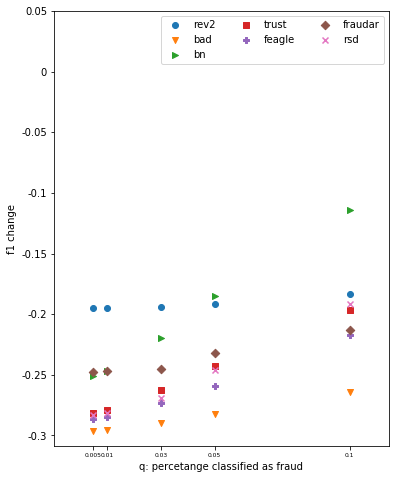

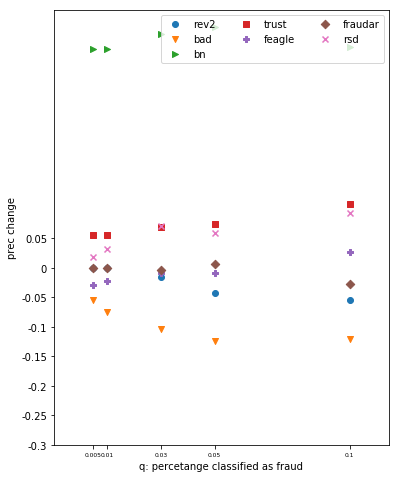

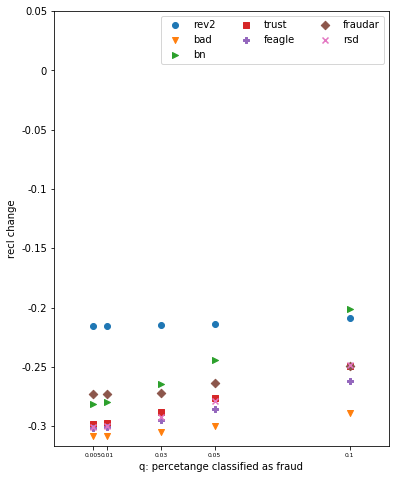

In [12]:
markers = ["o", "v", ">", "s", "P", "D", "x"]
def plot_scatters():
    
    u_change_dict = compute_uchange() 
    
    for i in range(3):        # ['f1', 'prec', 'recl']
        fig = plt.figure(i + 1, figsize=(6,8))     
        ax = fig.add_subplot(111)
        lines = []
        met = met_list[i]
        for alg_id in range(len(alg_list)):
        
            ax.scatter(q_range,  list(u_change_dict[alg_id][met].values()), 
                                       marker= markers[alg_id], label= alg_list[alg_id]) 
            ax.set_yticks([ -0.3, -0.25, -0.2,-0.15,  -0.1, -0.05, 0, 0.05]) # -0.6, -0.4,-1.0, -0.8,, 0.6, 0.8, 1.0])
            ax.set_yticklabels([ -0.3, -0.25, -0.2,-0.15,  -0.1, -0.05, 0, 0.05]) #-0.6, -0.4,,-1.0, -0.8,, 0.6, 0.8, 1.0])

            ax.set_xticks(q_range)
            ax.set_xticklabels(q_range, fontsize= 6)

            ax.set_xlabel('q: percetange classified as fraud')
            ax.set_ylabel('%s change' %met)
            
        ax.legend(
                loc='upper right',
                ncol=3,
                fontsize=10)
        
        fig.savefig('../res/scatter__%s.pdf' %(met_list[i]))
        
        

plot_scatters()

# #plot_scatterplots('bn', 'otc')
# #plot_scatterplots('bn', 'amazon')
# # plot_scatterplots('bn', 'epinions')
# # plot_scatterplots('rsd', 'epinions')
# #plot_scatterplots('fraudar', 'alpha')

no ../res/rev2/eval-otc.pkl
bad otc
bn otc
trust otc
feagle otc
fraudar otc
rsd otc
rev2 alpha
bad alpha
bn alpha
trust alpha
feagle alpha
fraudar alpha
rsd alpha
no ../res/rev2/eval-epinions.pkl
bad epinions
bn epinions
trust epinions
feagle epinions
fraudar epinions
rsd epinions
no ../res/rev2/eval-amazon.pkl
bad amazon
bn amazon
trust amazon
feagle amazon
fraudar amazon
rsd amazon
no ../res/rev2/eval-otc.pkl
bad otc
bn otc
trust otc
feagle otc
fraudar otc
rsd otc
rev2 alpha
bad alpha
bn alpha
trust alpha
feagle alpha
fraudar alpha
rsd alpha
no ../res/rev2/eval-epinions.pkl
bad epinions
bn epinions
trust epinions
feagle epinions
fraudar epinions
rsd epinions
no ../res/rev2/eval-amazon.pkl
bad amazon
bn amazon
trust amazon
feagle amazon
fraudar amazon
rsd amazon


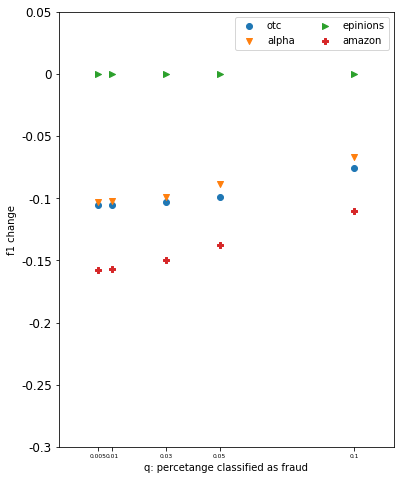

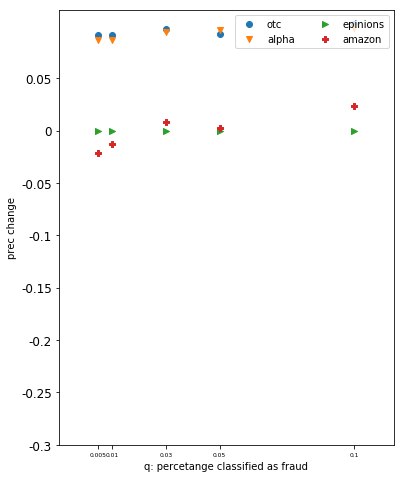

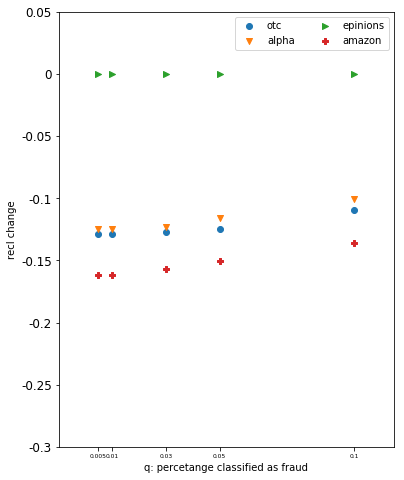

In [13]:
from collections import defaultdict

data_list = ['otc','alpha','epinions','amazon']
alg_list = ['rev2', 'bad', 'bn', 'trust', 'feagle', 'fraudar', 'rsd']

def compute_uchange():     #fig, ax, plot_data, title=''
    
    u_change_dict = {}     #u_change_dict[data_id][met][q] = average_uchange = sum of u_change / # of valid_alg (7)
    
    for data_id in range(len(data_list)): 
        u_change_dict[data_id] = {}     
        for met in met_list:
            u_change_dict[data_id][met] = {}
            
        for alg in alg_list:         
            eval_path = '../res/%s/eval-%s.pkl' %(alg, data_list[data_id])                            
            try:
                with open(eval_path, 'rb') as fp:
                    metrics_dict = pickle.load(fp)
            except FileNotFoundError:
                print("no ../res/%s/eval-%s.pkl" %(alg, data_list[data_id]))
                continue
            
            print(alg, data_list[data_id])
            
            
            q_dict = {}
            for q in range(5):
                heat_dict = {'f1': np.empty([10, 11]), 'prec': np.empty([10, 11]), 'recl': np.empty([10, 11])}
                
                try:
                    for k, n in itertools.product(range(10), range(11)):
                        heat_dict['f1'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['f1'][q_range[q]] for ind in range(50)])
                        heat_dict['prec'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['prec'][q_range[q]] for ind in range(50)])
                        heat_dict['recl'][k, n] = np.mean([metrics_dict[(k, n_range[n], ind)]['recl'][q_range[q]] for ind in range(50)])
                    q_dict[q] = heat_dict   
                except TypeError:
                    continue
            
            for q in range(5):  
                for met in met_list:
                    try:
                        # div = 0
                        u_new = q_dict[q][met][1:, :].min()
                        u_old = q_dict[q][met][0, :].mean()

                        k_new, n_new = np.unravel_index(q_dict[q][met][1:, :].argmin(), q_dict[q][met][1:, :].shape)                
                        k_new += 1

                        u_change = (u_new - u_old) / u_old
                        u_change_dict[data_id][met][q] = u_change_dict[data_id][met].get(q, 0) + u_change
                        # div += 1
               
                    except KeyError:
                        # print("KeyError !!!!")
                        # div -= 1
                        u_change_dict[data_id][met][q] = u_change_dict[data_id][met].get(q, 0)
                        continue
        
                    u_change_dict[data_id][met][q] /= 7
                    
                     
    return u_change_dict
    

u_change_dict = compute_uchange()


markers = ["o", "v", ">", "P"]   #markers for 4 datasets , "s", "D", "x"]
def plot_scatters():
    
    u_change_dict = compute_uchange() 
    
    for i in range(3):        # ['f1', 'prec', 'recl']
        fig = plt.figure(i + 1, figsize=(6,8))     
        ax = fig.add_subplot(111)
        met = met_list[i]
        
        for data_id in range(len(data_list)):
            u_change_list = list(u_change_dict[data_id][met].values())
#            print(u_change_list)
            if(len(u_change_list) != 5):
                print("%s not 5 values" %data_list[data_id])
                continue
            
            
            ax.scatter(q_range,  u_change_list, 
                                       marker= markers[data_id], label= data_list[data_id]) 
            ax.set_yticks([ -0.3, -0.25, -0.2,-0.15,  -0.1, -0.05, 0, 0.05]) # -0.6, -0.4,-1.0, -0.8,, 0.6, 0.8, 1.0])
            ax.set_yticklabels([ -0.3, -0.25, -0.2,-0.15,  -0.1, -0.05, 0, 0.05], fontsize=12) #-0.6, -0.4,,-1.0, -0.8,, 0.6, 0.8, 1.0])

            ax.set_xticks(q_range)
            ax.set_xticklabels(q_range, fontsize=6)

            ax.set_xlabel('q: percetange classified as fraud')
            ax.set_ylabel('%s change' %met)
            
        ax.legend(
                loc='upper right',
                ncol=2,
                fontsize=10)
        
        fig.savefig('../res/scatter_data_%s.pdf' %(met_list[i]))
        

plot_scatters()

In [13]:
reports = {met: {q: {alg: {data: {} for data in data_list} for alg in alg_list} for q in q_range} for met in met_list}

for alg in alg_list:
        for met in met_list:
            for q in range(5):
                print(alg, met, q_range[q], u_change_dict[alg][met][q])
        
        

KeyError: 'rev2'